Name : Sobhan Asasi

Student Number : 400206392

## Requirements

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchsummary import summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [2]:
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Hyperparameters
num_classes = 10
batch_size = 64
num_epochs = 10

# Part 1 : Fintuning of ResNet50

## Import Pretrained ResNet50

In [5]:
model = torchvision.models.resnet50(pretrained=True)

# Changing the requires grad of all layers to false
for param in model.parameters():
    param.requires_grad = False

# Change classifier layer
model.fc = nn.Linear(2048, num_classes)
torch.nn.init.xavier_uniform_(model.fc.weight)

# Test output size
input = torch.randn((1, 3 ,224, 224))
output = model(input)
print(output.shape)
#print(summary(model.to(device), (3 , 224, 224)))

torch.Size([1, 10])


## Dataset and Dataloader

In [6]:
train_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        #torchvision.transforms.AutoAugment(policy=torchvision.transforms.AutoAugmentPolicy.CIFAR10),
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize(mean, stdev)
    ])

train_dataset = torchvision.datasets.CIFAR10(root='data/' ,train=True, transform=train_transforms, download=True)
train_size = int(len(train_dataset) * 0.8)
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset,(train_size, valid_size))

test_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize(mean, stdev)
    ])

test_dataset = torchvision.datasets.CIFAR10(root='data/' ,train=False, transform=test_transforms, download=True)
#print(len(test_dataset))
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


## Loss and Optimizer

In [7]:
loss_fn = nn.CrossEntropyLoss()
sgd_learning_rate = 1e-2
sgd_opt = torch.optim.SGD(model.parameters(), lr=sgd_learning_rate, momentum=0.9)

## Train and Test loops

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer, results, device="cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        #print(pred.shape, y.shape)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    correct /= size
    results['train loss'].append(train_loss)
    results['train accuracy'].append(100*correct)
    print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

def valid_loop(dataloader, model, loss_fn, results, device="cpu", mode="valid"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    results['valid loss'].append(test_loss)
    results['valid accuracy'].append(100*correct)
    if mode == "valid":
        print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    else:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        

In [9]:
def train_valid(train_loader, valid_loader, loss_fn, optimizer, results, opt_name, model, epochs, device="cpu"):
    model.to(device)
    print(f"{opt_name}\n-------------------------------")
    for t in range(1, epochs+1):
      results['epoch'].append(t+1)
      print(f"Epoch {t}\n-------------------------------")
      #scheduler.step(t)
      train_loop(train_loader, model, loss_fn, optimizer, results, device=device)
      valid_loop(valid_loader, model, loss_fn, results, device=device)
    print("Done!")
    #torch.save(model, 'model_{}_{}.pth'.format(opt_name, epochs))
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.plot(list(range(epochs)), results['train accuracy'])
    plt.plot(list(range(epochs)), results['valid accuracy'])
    plt.title(f'Accuracy {opt_name}')
    plt.legend(['train accuracy', 'valid accuracy'])
    plt.subplot(122)
    plt.plot(list(range(epochs)), results['train loss'])
    plt.plot(list(range(epochs)), results['valid loss'])
    plt.title(f'Loss {opt_name}')
    plt.legend(['train loss', 'valid loss'])

SGD
-------------------------------
Epoch 1
-------------------------------
loss: 2.643905  [    0/40000]
Train Error: 
 Accuracy: 73.7%, Avg loss: 0.764909 

Validation Error: 
 Accuracy: 78.6%, Avg loss: 0.623102 

Epoch 2
-------------------------------
loss: 0.521628  [    0/40000]
Train Error: 
 Accuracy: 78.7%, Avg loss: 0.618446 

Validation Error: 
 Accuracy: 78.9%, Avg loss: 0.613464 

Epoch 3
-------------------------------
loss: 0.774713  [    0/40000]
Train Error: 
 Accuracy: 80.1%, Avg loss: 0.580942 

Validation Error: 
 Accuracy: 78.8%, Avg loss: 0.616008 

Epoch 4
-------------------------------
loss: 0.415023  [    0/40000]
Train Error: 
 Accuracy: 81.0%, Avg loss: 0.556673 

Validation Error: 
 Accuracy: 81.2%, Avg loss: 0.551396 

Epoch 5
-------------------------------
loss: 0.496217  [    0/40000]
Train Error: 
 Accuracy: 81.4%, Avg loss: 0.539383 

Validation Error: 
 Accuracy: 81.1%, Avg loss: 0.560857 

Epoch 6
-------------------------------
loss: 0.433766  [  

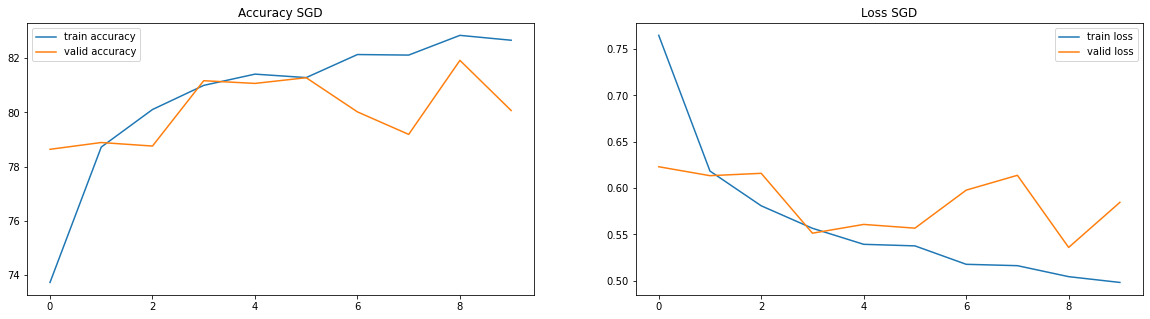

In [10]:
results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
train_valid(train_loader, valid_loader, loss_fn, sgd_opt, results, opt_name="SGD", model=model, epochs=num_epochs, device=device)
torch.save(model, 'ResNet50_fintune_CIFAR10.pth')

In [11]:
valid_loop(test_loader, model, loss_fn, results, device=device, mode="test")

Test Error: 
 Accuracy: 80.3%, Avg loss: 0.577999 



# Part 2: Knowledge Distillation

## Teacher : ResNet50

## Student : ResNet18

In [12]:
# Loading the teacher model
teach_model = torch.load('ResNet50_fintune_CIFAR10.pth')

In [13]:
# importing the student model
stu_model = torchvision.models.resnet18(pretrained=False)
stu_model.fc = nn.Linear(512, num_classes)
torch.nn.init.xavier_uniform_(stu_model.fc.weight)
summary(stu_model.to(device), (3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]          --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]          --
|

## Loss and Optimizer

In [14]:
loss_fn = nn.CrossEntropyLoss()
sgd_learning_rate = 1e-2
sgd_opt = torch.optim.SGD(stu_model.parameters(), lr=sgd_learning_rate, momentum=0.9)

## Train and Test loops

In [15]:
def train_loop(dataloader, stu_model, teach_model, loss_fn, optimizer, results, alpha=0.9, T=2.0, device="cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    stu_model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred_stu = stu_model(X)
        pred_teach = teach_model(X)/T
        # detach() method in PyTorch is used to separate a tensor from the computational graph by returning 
        # a new tensor that doesn't require a gradient
        pred_teach = pred_teach.detach()
        loss_stu = loss_fn(pred_stu, y)
        loss_stu_teach = loss_fn(pred_stu/T, pred_teach.softmax(dim=1))
        loss = (1 - alpha)*loss_stu + alpha*T*T*loss_stu_teach
        
        train_loss += loss.item()
        correct += (pred_stu.argmax(1) == y).type(torch.float).sum().item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    correct /= size
    results['train loss'].append(train_loss)
    results['train accuracy'].append(100*correct)
    print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

def valid_loop(dataloader, model, loss_fn, results, device="cpu", mode="valid"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    results['valid loss'].append(test_loss)
    results['valid accuracy'].append(100*correct)
    if mode == "valid":
        print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    else:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [16]:
def train_valid(train_loader, valid_loader, stu_model, teach_model, loss_fn, optimizer, results, opt_name, epochs, device="cpu"):
    stu_model.to(device)
    teach_model.to(device)
    print(f"{opt_name}\n-------------------------------")
    for t in range(1, epochs+1):
      results['epoch'].append(t+1)
      print(f"Epoch {t}\n-------------------------------")
      #scheduler.step(t)
      train_loop(train_loader, stu_model, teach_model, loss_fn, optimizer, results, device=device)
      valid_loop(valid_loader, stu_model, loss_fn, results, device=device)
    print("Done!")
    #torch.save(model, 'model_{}_{}.pth'.format(opt_name, epochs))
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.plot(list(range(epochs)), results['train accuracy'])
    plt.plot(list(range(epochs)), results['valid accuracy'])
    plt.title(f'Accuracy {opt_name}')
    plt.legend(['train accuracy', 'valid accuracy'])
    plt.subplot(122)
    plt.plot(list(range(epochs)), results['train loss'])
    plt.plot(list(range(epochs)), results['valid loss'])
    plt.title(f'Loss {opt_name}')
    plt.legend(['train loss', 'valid loss'])

SGD
-------------------------------
Epoch 1
-------------------------------
loss: 8.833413  [    0/40000]
Train Error: 
 Accuracy: 48.3%, Avg loss: 6.035586 

Validation Error: 
 Accuracy: 58.2%, Avg loss: 1.246594 

Epoch 2
-------------------------------
loss: 5.525794  [    0/40000]
Train Error: 
 Accuracy: 68.5%, Avg loss: 4.958334 

Validation Error: 
 Accuracy: 62.4%, Avg loss: 1.156433 

Epoch 3
-------------------------------
loss: 4.840415  [    0/40000]
Train Error: 
 Accuracy: 75.5%, Avg loss: 4.631238 

Validation Error: 
 Accuracy: 74.0%, Avg loss: 0.765830 

Epoch 4
-------------------------------
loss: 4.462900  [    0/40000]
Train Error: 
 Accuracy: 79.3%, Avg loss: 4.422740 

Validation Error: 
 Accuracy: 75.3%, Avg loss: 0.712933 

Epoch 5
-------------------------------
loss: 4.298988  [    0/40000]
Train Error: 
 Accuracy: 81.9%, Avg loss: 4.268447 

Validation Error: 
 Accuracy: 74.5%, Avg loss: 0.767873 

Epoch 6
-------------------------------
loss: 3.903087  [  

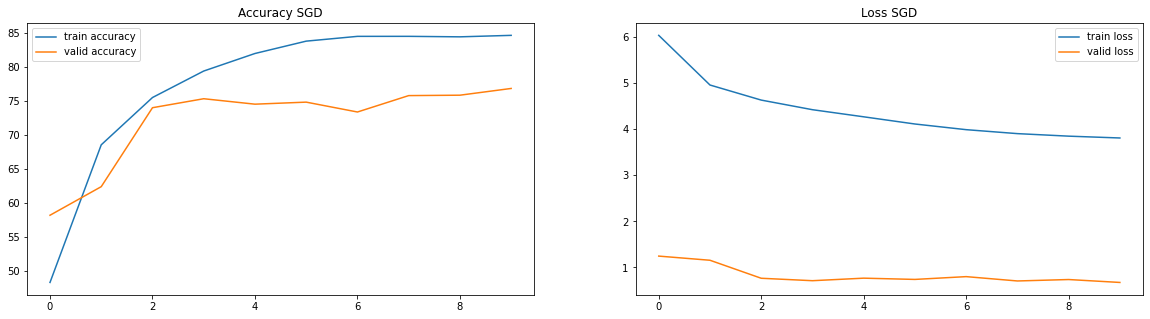

In [17]:
results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
train_valid(train_loader, valid_loader, stu_model, teach_model, loss_fn, sgd_opt, results, opt_name="SGD", epochs=num_epochs, device=device)
torch.save(stu_model, 'ResNet18_KD_CIFAR10.pth')

In [18]:
valid_loop(test_loader, stu_model, loss_fn, results, device=device, mode="test")

Test Error: 
 Accuracy: 76.6%, Avg loss: 0.692448 



# Part 3 : Training ResNet18(without teacher)

In [19]:
# importing the student model
resnet18 = torchvision.models.resnet18(pretrained=False)
resnet18.fc = nn.Linear(512, num_classes)
torch.nn.init.xavier_uniform_(resnet18.fc.weight)
print('')
#summary(resnet18.to(device), (3,224,224))

In [20]:
loss_fn = nn.CrossEntropyLoss()
sgd_learning_rate = 1e-2
sgd_opt = torch.optim.SGD(resnet18.parameters(), lr=sgd_learning_rate, momentum=0.9)

In [21]:
def train_loop(dataloader, model, loss_fn, optimizer, results, device="cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        #print(pred.shape, y.shape)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    correct /= size
    results['train loss'].append(train_loss)
    results['train accuracy'].append(100*correct)
    print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

def valid_loop(dataloader, model, loss_fn, results, device="cpu", mode="valid"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    results['valid loss'].append(test_loss)
    results['valid accuracy'].append(100*correct)
    if mode == "valid":
        print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    else:
        print(f"Test : \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [22]:
def train_valid(train_loader, valid_loader, loss_fn, optimizer, results, opt_name, model, epochs, device="cpu"):
    model.to(device)
    print(f"{opt_name}\n-------------------------------")
    for t in range(1, epochs+1):
        results['epoch'].append(t+1)
        print(f"Epoch {t}\n-------------------------------")
        #scheduler.step(t)
        train_loop(train_loader, model, loss_fn, optimizer, results, device=device)
        valid_loop(valid_loader, model, loss_fn, results, device=device)
    print("Done!")
    #torch.save(model, 'model_{}_{}.pth'.format(opt_name, epochs))
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.plot(list(range(epochs)), results['train accuracy'])
    plt.plot(list(range(epochs)), results['valid accuracy'])
    plt.title(f'Accuracy {opt_name}')
    plt.legend(['train accuracy', 'valid accuracy'])
    plt.subplot(122)
    plt.plot(list(range(epochs)), results['train loss'])
    plt.plot(list(range(epochs)), results['valid loss'])
    plt.title(f'Loss {opt_name}')
    plt.legend(['train loss', 'valid loss'])

SGD
-------------------------------
Epoch 1
-------------------------------
loss: 3.074129  [    0/40000]
Train Error: 
 Accuracy: 46.2%, Avg loss: 1.492667 

Validation Error: 
 Accuracy: 54.1%, Avg loss: 1.312411 

Epoch 2
-------------------------------
loss: 0.804499  [    0/40000]
Train Error: 
 Accuracy: 66.8%, Avg loss: 0.933485 

Validation Error: 
 Accuracy: 68.4%, Avg loss: 0.931418 

Epoch 3
-------------------------------
loss: 0.755530  [    0/40000]
Train Error: 
 Accuracy: 76.1%, Avg loss: 0.681849 

Validation Error: 
 Accuracy: 65.9%, Avg loss: 1.019373 

Epoch 4
-------------------------------
loss: 0.393877  [    0/40000]
Train Error: 
 Accuracy: 82.5%, Avg loss: 0.501623 

Validation Error: 
 Accuracy: 69.8%, Avg loss: 0.967161 

Epoch 5
-------------------------------
loss: 0.324141  [    0/40000]
Train Error: 
 Accuracy: 88.0%, Avg loss: 0.341890 

Validation Error: 
 Accuracy: 66.2%, Avg loss: 1.228552 

Epoch 6
-------------------------------
loss: 0.292894  [  

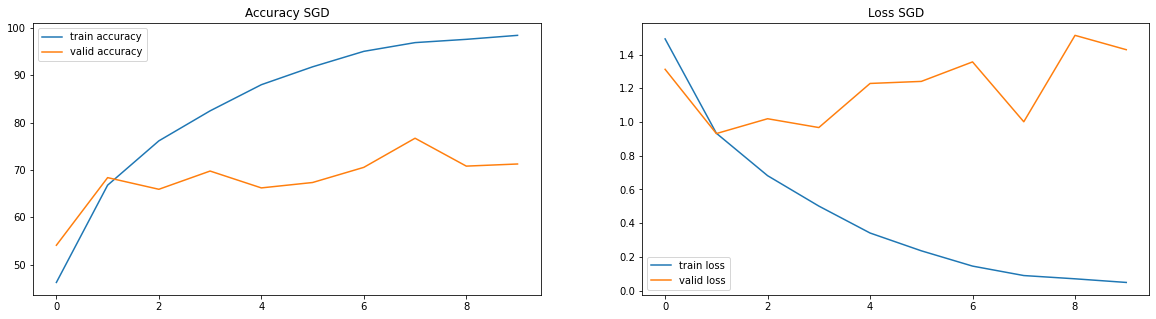

In [23]:
results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
train_valid(train_loader, valid_loader, loss_fn, sgd_opt, results, opt_name="SGD", model=resnet18, epochs=num_epochs, device=device)
torch.save(resnet18, 'ResNet18_CIFAR10.pth')

In [24]:
valid_loop(test_loader, resnet18, loss_fn, results, device=device, mode="test")

Test : 
 Accuracy: 71.6%, Avg loss: 1.407066 



## Comapring results

- ResNet18(Student) + ResNet50(Teacher) -> Train Accuracy : 84.6% , Test Accuracy : 76.6%
- ResNet18 -> Train Accuracy : 98.4% , Test Accuracy : 71.6%

- As the results show, when we use techer model for resnet18 training, we have better test accuracy.
- In KD algorithm we are using two models and then voting between their results and it causes better result and lower generalization error. Its a bit like ensemble learning and prevent overfitting.
- But when we use just resnet18, in spite of better training accuracy but we have lower test accuracy. It shows that the model just learn and memorize training samples.

# Part 4 : Training ResNet50

In [25]:
# importing the student model
resnet50 = torchvision.models.resnet50(pretrained=False)
resnet50.fc = nn.Linear(2048, num_classes)
torch.nn.init.xavier_uniform_(resnet50.fc.weight)
print('')
#summary(resnet18.to(device), (3,224,224))

In [26]:
loss_fn = nn.CrossEntropyLoss()
sgd_learning_rate = 1e-2
sgd_opt = torch.optim.SGD(resnet50.parameters(), lr=sgd_learning_rate, momentum=0.9)

In [27]:
def train_loop(dataloader, model, loss_fn, optimizer, results, device="cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        #print(pred.shape, y.shape)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    correct /= size
    results['train loss'].append(train_loss)
    results['train accuracy'].append(100*correct)
    print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

def valid_loop(dataloader, model, loss_fn, results, device="cpu", mode="valid"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    results['valid loss'].append(test_loss)
    results['valid accuracy'].append(100*correct)
    if mode == "valid":
        print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    else:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [28]:
def train_valid(train_loader, valid_loader, loss_fn, optimizer, results, opt_name, model, epochs, device="cpu"):
    model.to(device)
    print(f"{opt_name}\n-------------------------------")
    for t in range(1, epochs+1):
      results['epoch'].append(t+1)
      print(f"Epoch {t}\n-------------------------------")
      #scheduler.step(t)
      train_loop(train_loader, model, loss_fn, optimizer, results, device=device)
      valid_loop(valid_loader, model, loss_fn, results, device=device)
    print("Done!")
    #torch.save(model, 'model_{}_{}.pth'.format(opt_name, epochs))
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.plot(list(range(epochs)), results['train accuracy'])
    plt.plot(list(range(epochs)), results['valid accuracy'])
    plt.title(f'Accuracy {opt_name}')
    plt.legend(['train accuracy', 'valid accuracy'])
    plt.subplot(122)
    plt.plot(list(range(epochs)), results['train loss'])
    plt.plot(list(range(epochs)), results['valid loss'])
    plt.title(f'Loss {opt_name}')
    plt.legend(['train loss', 'valid loss'])

SGD
-------------------------------
Epoch 1
-------------------------------
loss: 2.903503  [    0/40000]
Train Error: 
 Accuracy: 32.6%, Avg loss: 1.975894 

Validation Error: 
 Accuracy: 43.6%, Avg loss: 1.706859 

Epoch 2
-------------------------------
loss: 1.799810  [    0/40000]
Train Error: 
 Accuracy: 48.8%, Avg loss: 1.412949 

Validation Error: 
 Accuracy: 54.0%, Avg loss: 1.307501 

Epoch 3
-------------------------------
loss: 1.209891  [    0/40000]
Train Error: 
 Accuracy: 58.9%, Avg loss: 1.155599 

Validation Error: 
 Accuracy: 61.4%, Avg loss: 1.246021 

Epoch 4
-------------------------------
loss: 0.976305  [    0/40000]
Train Error: 
 Accuracy: 66.8%, Avg loss: 0.928000 

Validation Error: 
 Accuracy: 68.2%, Avg loss: 1.003836 

Epoch 5
-------------------------------
loss: 0.880528  [    0/40000]
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.761870 

Validation Error: 
 Accuracy: 71.3%, Avg loss: 1.400713 

Epoch 6
-------------------------------
loss: 0.575134  [  

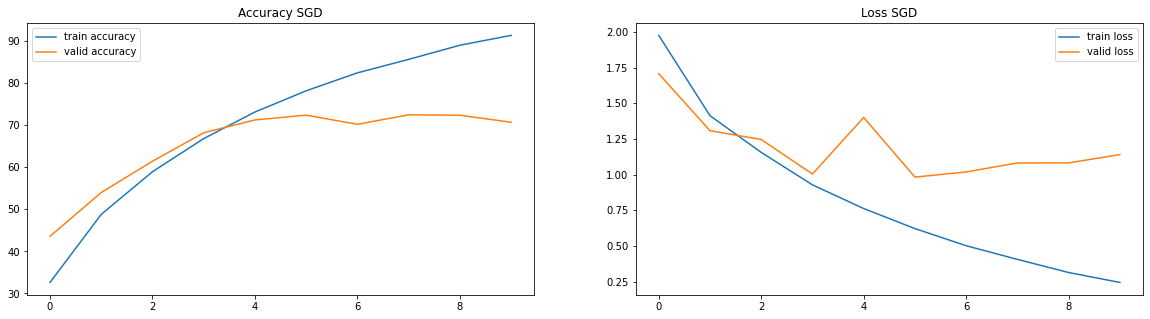

In [29]:
results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
train_valid(train_loader, valid_loader, loss_fn, sgd_opt, results, opt_name="SGD", model=resnet50, epochs=num_epochs, device=device)
torch.save(resnet50, 'ResNet50_CIFAR10.pth')

In [30]:
valid_loop(test_loader, resnet50, loss_fn, results, device=device, mode="test")

Test Error: 
 Accuracy: 70.9%, Avg loss: 1.147585 



## Comapring the results

- Pre-trained ResNet50 -> Train Accuracy : 82% , Test Accuracy : 80% 
- ResNet50 -> Train Accuracy : 91.4% , Test Accuracy : 70.9%

- By considering the results, when we train a complete resnet50 we have better train accuracy, because we are traing more layers than just a fully-connected layer in pretrained model.
- As the results show, when we train all layers there is a significant difference between train and test accuracy because resnet50 is so complicated model for CIFAR-10 dataset and it causes overfitting. 